In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv
from ast import literal_eval

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.inspection import permutation_importance


In [25]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column

df = pd.read_csv('data_file.csv', converters={'NDVI': literal_eval, 'NBR': literal_eval})
df.head()


SyntaxError: invalid syntax (<unknown>, line 3)

In [14]:
# Split data into training and test set

X = df[['NDVI', 'NBR']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [15]:
# Classifier used: Radial Basis Function (RBF)
# it can combine multiple polynomial kernels multiple times of different degrees to
# project the non-linearly separable data into higher dimensional space

# gamma: https://www.ibm.com/docs/sr/spss-modeler/18.0.0?topic=node-svm-expert-options
# C: https://vitalflux.com/svm-rbf-kernel-parameters-code-sample/
rbf = svm.SVC(kernel='rbf', gamma=1.5, C=5).fit(X_train, y_train)


ValueError: could not convert string to float: '[[0.84183044 0.79869815 0.8062327  ... 0.85879701 0.75102635 0.80507178]\n [0.84315056 0.7057488  0.77036677 ... 0.86374754 0.86344884 0.85700554]\n [0.76581941 0.70920425 0.75885903 ... 0.80382348 0.8516807  0.83389535]\n ...\n [0.21693394 0.20446548 0.2122786  ... 0.10374946 0.21461744 0.17202047]\n [0.17445914 0.20381305 0.21288072 ... 0.30097119 0.43220652 0.37563918]\n [0.30439025 0.2351206  0.25417563 ... 0.67954823 0.70124094 0.70024931]]'

In [67]:
# Calculate model efficiency

rbf_pred = rbf.predict(X_test)


In [68]:
# Calculate the accuracy and f1 scores for SVM with RBF kernel

rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_precision = precision_score(y_test, rbf_pred, average='macro')
rbf_recall = recall_score(y_test, rbf_pred, average='macro')
rbf_average_precision = average_precision_score(y_test, rbf_pred, average='macro')

print(f"Accuracy: {rbf_accuracy:.4f}")
print(f"Precision: {rbf_precision:.4f}")
print(f"Recall: {rbf_recall:.4f}")
print(f"Mean Average Precision: {rbf_average_precision:.4f}")

print(classification_report(y_test, rbf_pred))
print(confusion_matrix(y_test, rbf_pred))


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Mean Average Precision: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[1 0]
 [0 7]]


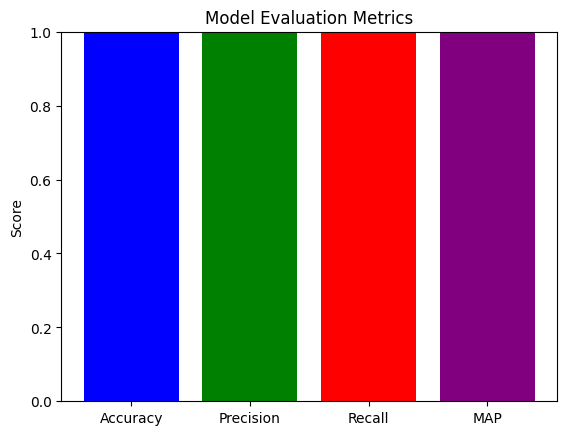

In [69]:
# Visualize the model evaluation metrics

metrics = ['Accuracy', 'Precision', 'Recall', 'MAP']
values = [rbf_accuracy, rbf_precision, rbf_recall, rbf_average_precision]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # to set y-axis limits from 0 to 1
plt.show()


Text(0.5, 0, 'Permutation Importance')

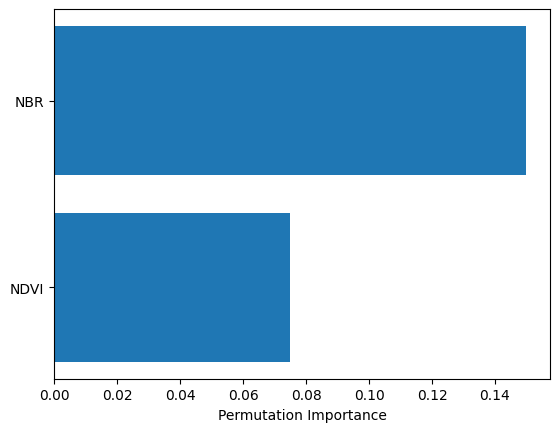

In [70]:
perm_importance = permutation_importance(rbf, X_test, y_test)
features = np.array(X.columns)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
